# AlBi 3
### Übungsblatt 2
*Markus Apel, Mathias Husted*

### Aufgabe 1a)

Es handelt sich um das Protein "Immunoglobulin binding protein"

### Aufgabe 1b, 1c, 1d)



In [38]:
import numpy as np
from Bio.PDB import PDBParser
from Bio.PDB.Polypeptide import is_aa, three_to_index, index_to_one


class AtomReader:
    def __init__(self, filepath):
        self.parser = PDBParser(QUIET=True)
        self.structure = self.parser.get_structure("structure", filepath)
        self.atom_positions = {}
        # Initialize atom positions
        for model in self.structure:
            for chain in model:
                if chain.id not in self.atom_positions:
                    self.atom_positions[chain.id] = []
                for id, residue in enumerate(chain):
                    if is_aa(residue, standard=True):
                        self.atom_positions[chain.id].append({
                            "id": id,
                            "Residue": residue.get_resname(),
                            "C": None,
                            "O": None,
                            "N": None,
                            "H": None
                        })
                        if "C" in residue:
                            self.atom_positions[chain.id][id]["C"] = residue["C"].get_coord()
                        if "O" in residue:
                            self.atom_positions[chain.id][id]["O"] = residue["O"].get_coord()
                        if "N" in residue:
                            self.atom_positions[chain.id][id]["N"] = residue["N"].get_coord()
                        if "H" in residue:
                            self.atom_positions[chain.id][id]["H"] = residue["H"].get_coord()
    
    def get_sequence(self):
        sequences = {}
        for model in self.structure:
            for chain in model:
                seq = ""
                for residue in chain:
                    if is_aa(residue, standard=True):
                        resname = residue.get_resname()
                        #seq += residue.get_resname() + " "
                        seq += index_to_one(three_to_index(resname))
                sequences[chain.id] = seq
        return sequences
    
    def get_positions(self):
        return self.atom_positions
    
    def get_energy(self):
        if self.atom_positions is None:
            return None
        
        h_bond = {}

        for chain_id, residues in self.atom_positions.items():
            for i, donor in enumerate(residues):
                if donor["N"] is None or donor["H"] is None:
                    continue
                for j, acceptor in enumerate(residues):
                    if acceptor["O"] is None or acceptor["C"] is None:
                        continue
                    if abs(i - j) < 2:
                        continue 

                    r_on = np.linalg.norm(acceptor["O"] - donor["N"])
                    r_ch = np.linalg.norm(acceptor["C"] - donor["H"])
                    r_oh = np.linalg.norm(acceptor["O"] - donor["H"])
                    r_cn = np.linalg.norm(acceptor["C"] - donor["N"])

                    e = 0.084 * ((1/r_on) + (1/r_ch) - (1/r_oh) - (1/r_cn)) * 332
                    #h_bond.append(e < -0.5)
                    if donor["id"] not in h_bond:
                        h_bond[donor["id"]] = {}
                    h_bond[donor["id"]][acceptor["id"]] = True if e < -0.5 else False

        return h_bond
    
    def sec_structure(self, h_bond):
        bond_type = {} # True = Turn, False = Bridge
        for donor in h_bond:
            for acceptor in h_bond[donor]:
                if not h_bond[donor][acceptor]:
                    continue
                if donor not in bond_type:
                    bond_type[donor] = {}
                dist = abs(acceptor - donor)
                #print(f"Current h_bond pair: h_bond[{donor}][{acceptor}]: {h_bond[donor][acceptor]} with distance {dist}")
                if dist in (3, 4, 5):
                    bond_type[donor][acceptor] = True
                else:
                    bond_type[donor][acceptor] = False
                    continue

        # Now our compact list of turns/bridges is created -> check for a-helices first
        last_donor, last_acceptor = None, None
        current_helix = []
        helices = []
        for donor in sorted(bond_type.keys()):
            for acceptor in sorted(bond_type[donor].keys()):
                if not bond_type[donor][acceptor]:
                    # Value is False => Bridge, not turn, hence can't be part of an a-helix
                    continue
                if last_donor is not None and last_acceptor is not None:
                    if (donor - last_donor == 1) and (acceptor - last_acceptor == 1):
                        current_helix.append((donor, acceptor))
                    else:
                        # >= 2 turns => helix!
                        if len(current_helix) >= 2:
                            helices.append(current_helix)
                        current_helix = [(donor, acceptor)]
                else:
                    current_helix = [(donor, acceptor)]

                last_donor, last_acceptor = donor, acceptor
        # Final helix (if exists)
        if len(current_helix) >= 2:
            helices.append(current_helix)
        

        # Final step: Merge helices which are within 2-3 residues
        merged_helices = []
        if helices:
            merged = helices[0]
            for h in helices[1:]:
                prev_end = max(merged[-1][0], merged[-1][1])
                next_start = min(h[0][0], h[0][1])
                if next_start - prev_end <= 3:
                    merged.extend(h)
                else:
                    merged_helices.append(merged)
                    merged = h
            merged_helices.append(merged)
        else:
            merged_helices = []

        # Next: Beta sheets

        sheets = []
        visited = set()

        for donor in sorted(bond_type.keys()):
            for acceptor in sorted(bond_type[donor].keys()):
                if bond_type[donor][acceptor]:
                    continue # Sort out helices

                reciprocal = False
                for offset in (-1, 0, 1):
                    if (
                        acceptor + offset in h_bond
                        and donor + offset in h_bond[acceptor + offset]
                        and h_bond[acceptor + offset][donor + offset]
                    ):
                        reciprocal = True
                        break

                if not reciprocal:
                    continue

                if (donor, acceptor) in visited or (acceptor, donor) in visited:
                    continue
                visited.add((donor, acceptor))
                visited.add((acceptor, donor))

                sheet = [(donor, acceptor)]
                next_d, next_a = donor + 1, acceptor + 1
                while (
                    next_d in h_bond
                    and next_a in h_bond[next_d]
                    and h_bond[next_d][next_a]
                    and abs(next_a - next_d) > 5
                ):
                    sheet.append((next_d, next_a))
                    next_d += 1
                    next_a += 1
                sheets.append(sheet)



        return merged_helices, sheets



reader = AtomReader("1PGA.pdb")

print(f"Sequence: {reader.get_sequence()['A']}")

h_bond = reader.get_energy()

helices, sheets = reader.sec_structure(h_bond)

for helix in helices:
    print(f"Alpha-helix detected in residues {helix[0][0]}-{helix[-1][1]}")

for sheet in sheets:
    residues = [r for pair in sheet for r in pair]
    start, end = min(residues), max(residues)
    print(f"Beta-sheet detected between residues {start}-{end}")

Sequence: MTYKLILNGKTLKGETTTEAVDAATAEKVFKQYANDNGVDGEWTYDDATKTFTVTE
Alpha-helix detected in residues 25-34
Beta-sheet detected between residues 2-17
Beta-sheet detected between residues 4-15
Beta-sheet detected between residues 6-13
Beta-sheet detected between residues 41-54
Beta-sheet detected between residues 43-52


### Aufgabe 1e)

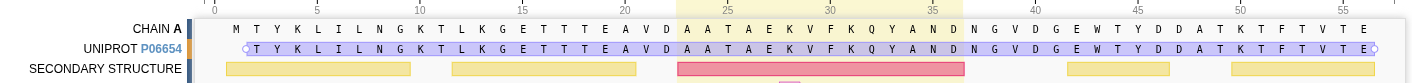

Es ist zu erkennen, dass bei der Erfassung der $\alpha$-Helices eine gute Erkennung gab, während es bei den $\beta$-Faltblättern auch Überschneidungen gibt, es hier aber weniger eindeutig war.

### Aufgabe 2a)

Alphafold 2 löst den "heiligen Gral" der Bioinformatik: Die 3D-Struktur mit allen Sekundärstrukturen (Faltung) eines Proteins vorherzusagen anhand der Aminosäurensequenz.

### Aufgabe 2b)
Alphafold 2 besteht aus drei grundsätzlichen Schritten, die weiter unterteilt werden.

In einem ersten Schritt wird die Aminosäurensequenz eingeladen. Sie wird eingespeist in ein MSA, welches in einer Datenbank nach verwandten Proteinen mit konservierten Resten sucht und sie anschließend aliniert.
Parallel wird ein Pairing durchgeführt, sowie in einer anderen Strukturdatenbank nach bereits bekannten 3D Strukturen, die in unserem gesuchten Protein auch konserviert sein könnten.

Danach werden beiden fusionierten Repräsentationen jeweils in einen Embedding Space überführt, woraus sie in das aus 48 Schichten bestehende transformerbasierte Evoformer-Modul gefüttert werden. Daraus entstehen auch wieder zwei Repräsentationen, die drei Mal wieder "recycelt", also wieder als Eingabe für die Wiederholung des Evoformers benutzt werden.

Nach den drei Iterationen werden die beiden Embeddings als Letztes in das Strukturmodul eingelesen, welches anhand dieser eine 3D-Struktur erstellen kann. Das Strukturmodul beachtet auch physikalische Plausibilitäten, indem es u.a. jede Aminosäure als "Dreieck" im Raum betrachtet und vom Modell durch Translationen und Rotationen angeordnet. Auch die Seitenketten werden über Torsionswinkel mit modelliert. Auch dieser letzte Schritt durchläuft "Recycling", wird also mehrmals wiederholt, um die Ergebnisse zu optimieren.



### Aufgabe 2c)

In einem MSA zeigen gemeinsam mutierende Positionen (kovariante Reste) funktionelle oder strukturelle Abhängigkeiten. Diese Korrelationen weisen auf räumliche Nähe hin und helfen, Kontakte und damit die 3D-Faltung vorherzusagen.

### Aufgabe 2d)

Templates liefern zusätzliche geometrische Anhaltspunkte selbst bei Unterschieden, da konservierte Bereiche oft ähnliche Faltungen behalten. So kann das Modell bekannte Strukturmuster auch auf teils abweichende Sequenzen übertragen.


### Aufgabe 3a)

In [56]:
import random

def generate_sequence(length):
    sequence = ""
    for x in range(length):
        rand_int = random.randint(0, 19)
        sequence += index_to_one(rand_int)
    return sequence


hydrophobic_aa = ['A', 'I', 'L', 'M', 'F', 'W', 'V']
hydrophilic_aa = ['R', 'K', 'E', 'D', 'N', 'Q', 'S', 'T']
def generate_sequence_alternate(length):
    sequence = ""
    i = 0
    while len(sequence) < length:
        for x in range(3):
            if not len(sequence) < length:
                break
            sequence += random.choice(hydrophobic_aa)
        for x in range(2):
            if not len(sequence) < length:
                break
            sequence += random.choice(hydrophilic_aa)
    return sequence


sequence = generate_sequence(30)
sequence_alt = generate_sequence_alternate(30)
print(f"Sequence 1: {sequence}\nSequence 2: {sequence_alt}")

Sequence 1: PYVKSAHQSERPHKCYKDWIFLNICKIMLG
Sequence 2: VAWTSMIIKSWWAKTILLRQVWFDQAMWQK


### Aufgabe 3b, 3c)

Wir haben nun die beiden Sequenzen `PYVKSAHQSERPHKCYKDWIFLNICKIMLG` sowie `VAWTSMIIKSWWAKTILLRQVWFDQAMWQK` erhalten.

Bei der Eingabe in Alphafold kam für beide leider keine 3D Struktur aus, der Viewer scheint dort browserunabhängig nicht zu funktionieren und gab nur ein weißes Bild aus.

Allerdings würde man vermuten, dass die erste Sequenz eine zufälligere Struktur hat, die nicht gut vorhersagbar ist. Die zweite mit abwechselnd hydrophilen und hydrophoben Bereichen würde man typischerweise an der Oberfläche von Proteinen oder in Membranproteinen erwarten. Dabei tendieren die hydrophoben Bereiche dazu, sich nach innen zu richten, während die hydrophilen eher nach außen (zur wässrigen Umgebung) ausgerichtet sind.